In [1]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

ARTIF_DIR = Path("../app/artifacts")
ARTIF_DIR.mkdir(parents=True, exist_ok=True)
EVAL_DIR = Path("../app/artifacts/eval")
EVAL_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
df = pd.read_csv("../data/df_file.csv")
X_raw, y = df["Text"].astype(str).tolist(), df["Label"].values
tfidf = joblib.load(ARTIF_DIR / "tfidf.pkl")

# làm sạch nhẹ nhàng cho nhất quán:
X = [t.replace("\n", " ").strip() for t in X_raw]


In [3]:
knn = KNeighborsClassifier(n_neighbors=5, metric="cosine", weights="uniform")
pipe = make_pipeline(tfidf, knn)


In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, f1s = [], []
fold_preds = []
fold_trues = []

for fold, (tr, te) in enumerate(skf.split(X, y), 1):
    pipe.fit([X[i] for i in tr], y[tr])
    p = pipe.predict([X[i] for i in te])

    accs.append(accuracy_score(y[te], p))
    f1s.append(f1_score(y[te], p, average="macro"))

    fold_preds.extend(p)
    fold_trues.extend(y[te])

print(f"CV-ACC: {np.mean(accs):.4f} ± {np.std(accs):.3f}")
print(f"CV-F1 (macro): {np.mean(f1s):.4f} ± {np.std(f1s):.3f}")


CV-ACC: 0.9622 ± 0.007
CV-F1 (macro): 0.9614 ± 0.007


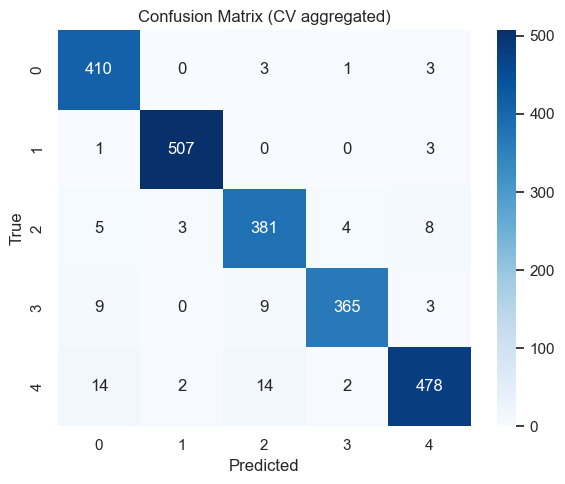

Saved CM, report, and per-fold scores.


In [5]:
cm = confusion_matrix(fold_trues, fold_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (CV aggregated)")
plt.tight_layout()
plt.savefig(EVAL_DIR / "knn_cv_confusion_matrix.png", dpi=160)
plt.show()

report = classification_report(fold_trues, fold_preds, output_dict=True)
pd.DataFrame(report).to_csv(EVAL_DIR / "knn_cv_classification_report.csv")
pd.DataFrame({"ACC":accs, "F1_macro":f1s}).to_csv(EVAL_DIR / "knn_cv_scores.csv", index=False)
print("Saved CM, report, and per-fold scores.")


In [6]:
pipe.fit(X, y)
joblib.dump(pipe, ARTIF_DIR / "knn_clf.pkl")
print("Saved ->", ARTIF_DIR / "knn_clf.pkl")


Saved -> ..\app\artifacts\knn_clf.pkl


In [7]:
# Lấy ra 3 văn bản test ngẫu nhiên
np.random.seed(42)
sample_ids = np.random.choice(len(X), size=3, replace=False)

# rút ra các thành phần trong pipeline
vec = pipe.named_steps["tfidfvectorizer"]
knn = pipe.named_steps["kneighborsclassifier"]

# ma trận toàn bộ để dùng kneighbors
X_vec = vec.transform(X)

rows = []
for sid in sample_ids:
    qv = X_vec[sid]
    dist, idx = knn.kneighbors(qv, n_neighbors=5, return_distance=True)
    sim = 1 - dist[0]  # cosine similarity = 1 - distance

    rows.append({
        "sample_id": int(sid),
        "text_snippet": X[sid][:180] + ("..." if len(X[sid])>180 else ""),
        "true_label": int(y[sid]),
        "neighbors_idx": idx[0].tolist(),
        "neighbors_sim": [float(s) for s in sim],
        "neighbors_labels": [int(y[i]) for i in idx[0]],
    })

pd.DataFrame(rows).to_json(EVAL_DIR / "knn_neighbors_examples.json", orient="records", force_ascii=False)
rows[:1]


[{'sample_id': 414,
  'text_snippet': 'David Blunkett in quotes    David Blunkett - who has resigned as home secretary - built his reputation as a plain-speaking Yorkshire man.          I fell in love with someone and t...',
  'true_label': 0,
  'neighbors_idx': [414, 54, 169, 165, 225],
  'neighbors_sim': [0.9999999999999996,
   0.2709813794736937,
   0.11838102753964586,
   0.11344802921592845,
   0.10262502959943265],
  'neighbors_labels': [0, 0, 0, 0, 0]}]

In [8]:
from sklearn.model_selection import ParameterGrid

grid = {
    "k": [3,5,7,11],
    "weights": ["uniform","distance"]
}
best = {"score": -1, "cfg": None}

Xv = tfidf.transform(X)  # dùng lại vectorizer đã fit

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for g in ParameterGrid(grid):
    tmp_knn = KNeighborsClassifier(n_neighbors=g["k"], metric="cosine", weights=g["weights"])
    f1s = []
    for tr, te in skf.split(Xv, y):
        tmp_knn.fit(Xv[tr], y[tr])
        p = tmp_knn.predict(Xv[te])
        f1s.append(f1_score(y[te], p, average="macro"))
    score = np.mean(f1s)
    print(g, "-> F1:", round(score,4))
    if score > best["score"]:
        best = {"score": score, "cfg": g}

print("Best:", best)
pd.Series(best).to_json(EVAL_DIR / "knn_grid_best.json")


{'k': 3, 'weights': 'uniform'} -> F1: 0.9637
{'k': 3, 'weights': 'distance'} -> F1: 0.9672
{'k': 5, 'weights': 'uniform'} -> F1: 0.9601
{'k': 5, 'weights': 'distance'} -> F1: 0.9672
{'k': 7, 'weights': 'uniform'} -> F1: 0.9677
{'k': 7, 'weights': 'distance'} -> F1: 0.97
{'k': 11, 'weights': 'uniform'} -> F1: 0.9685
{'k': 11, 'weights': 'distance'} -> F1: 0.9712
Best: {'score': 0.971214513230364, 'cfg': {'k': 11, 'weights': 'distance'}}
